# Embed, Encode and Predict

In [1]:
from __future__ import division, print_function
from keras.layers import Input
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "../data"

VOCAB_FILE = os.path.join(DATA_DIR, "ng-vocab.tsv")
MIN_OCCURS = 5

GLOVE_FILE = os.path.join(DATA_DIR, "glove.840B.300d.txt")

# covers about 95% of input data
MAX_SENTS = 40 # maximum number of sentences per document
MAX_WORDS = 60 # maximum number of words per sentence

WORD_EMBED_SIZE = 300
SENT_EMBED_SIZE = 100
DOC_EMBED_SIZE = 50
NUM_CLASSES = 20

BATCH_SIZE = 64
NUM_EPOCHS = 10

logging.basicConfig()

## Load Vocabulary

In [3]:
word2id = {"PAD": 0, "UNK": 1}
fvocab = open(VOCAB_FILE, "rb")
for i, line in enumerate(fvocab):
    word, count = line.strip().split("\t")
    if int(count) <= MIN_OCCURS:
        break
    word2id[word] = i
fvocab.close()
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id)
print("vocab_size: {:d}".format(vocab_size))

vocab_size: 40730


## Load GloVe Embeddings

In [4]:
E = np.zeros((vocab_size, WORD_EMBED_SIZE))
E[1] = np.random.random(WORD_EMBED_SIZE)
fglove = open(GLOVE_FILE, "rb")
for line in fglove:
    cols = line.strip().split(" ")
    word = cols[0]
    if not word2id.has_key(word):
        continue
    vec = np.array([float(x) for x in cols[1:]])
    idx = word2id[word]
    E[idx] = vec
fglove.close()
print(E.shape)

(40730, 300)


## Compute Document Vectors

In [5]:
ng_data = fetch_20newsgroups(subset='all',
                             data_home=DATA_DIR,
                             shuffle=True, 
                             random_state=42)
num_docs = len(ng_data.data)
print(num_docs)

18846


In [6]:
def pad_or_truncate(xs, maxlen):
    if len(xs) > maxlen:
        xs = xs[len(xs) - maxlen:]
    elif len(xs) < maxlen:
        xs = ["PAD"] * (maxlen - len(xs)) + xs
    return xs

xs = ["The", "cat", "fought", "like", "a", "mouse"]
print(pad_or_truncate(xs, 3))
print(pad_or_truncate(xs, 7))

['like', 'a', 'mouse']
['PAD', 'The', 'cat', 'fought', 'like', 'a', 'mouse']


In [7]:
X = np.zeros((num_docs, MAX_SENTS, MAX_WORDS))
for docid in range(num_docs):
    text = ng_data.data[docid]
    sents = pad_or_truncate(nltk.sent_tokenize(text), MAX_SENTS)
    for sid, sent in enumerate(sents):
        words = nltk.word_tokenize(sent)
        words = pad_or_truncate(words, MAX_WORDS)
        for wid, word in enumerate(words):
            try:
                word_id = word2id[word]
            except KeyError:
                word_id = word2id["UNK"]
            X[docid, sid, wid] = word_id
print(X.shape)

(18846, 40, 60)


In [8]:
y = ng_data.target
Y = to_categorical(y, num_classes=NUM_CLASSES)
print(Y.shape)

(18846, 20)


In [9]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.7)
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(13192, 40, 60) (13192, 20) (5654, 40, 60) (5654, 20)


## Define Network

__Note:__ 

Not initializing the Embedding weights with the GloVe vectors resulted in a slightly worse performance (test set accuracy of 0.806 compared to 0.826 here, and training set accuracy of 0.9954 compared to 0.9950 here). 

On the other hand, setting the weights and making the embedding layer non-trainable resulted in significantly worse performance, ie, a test set accuracy of 0.643 and training set accuracy of 0.9552 even after 50 epochs of training. One possible reason is that making the embedding layer non-trainable drops the number of trainable parameters from 12,540,970 to 321,970 (about 10x our base embed-predict BoW model with 32,120 parameters).

In [10]:
inputs = Input(shape=(MAX_SENTS, MAX_WORDS,))

emb_words = TimeDistributed(Embedding(input_dim=vocab_size, 
                                      output_dim=WORD_EMBED_SIZE,
                                      weights=[E],
                                      mask_zero=True))(inputs)

emb_sents = TimeDistributed(Bidirectional(
    GRU(SENT_EMBED_SIZE, return_sequences=True)))(emb_words)
emb_sents = TimeDistributed(GlobalMaxPooling1D())(emb_sents)

emb_docs = Bidirectional(
    GRU(DOC_EMBED_SIZE, return_sequences=True))(emb_sents)
emb_docs = GlobalMaxPooling1D()(emb_docs)

fc1_dropout = Dropout(0.2)(emb_docs)
fc1 = Dense(50, activation="relu")(fc1_dropout)
fc2_dropout = Dropout(0.2)(fc1)
outputs = Dense(NUM_CLASSES, activation="softmax")(fc2_dropout)

In [11]:
model = Model(inputs=inputs, outputs=outputs)

In [12]:
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 60)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 60, 300)       12219000  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 40, 60, 200)       240600    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 40, 200)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 40, 100)           75300     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
__________

In [14]:
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS, validation_split=0.1)

Train on 11872 samples, validate on 1320 samples
Epoch 1/10
11872/11872 [==============================] - 135s - loss: 2.8229 - acc: 0.0964 - val_loss: 2.2800 - val_acc: 0.2424
Epoch 2/10
11872/11872 [==============================] - 132s - loss: 1.5965 - acc: 0.4698 - val_loss: 0.9604 - val_acc: 0.7076
Epoch 3/10
11872/11872 [==============================] - 132s - loss: 0.6851 - acc: 0.7890 - val_loss: 0.7083 - val_acc: 0.7924
Epoch 4/10
11872/11872 [==============================] - 133s - loss: 0.3184 - acc: 0.9062 - val_loss: 0.7333 - val_acc: 0.8076
Epoch 5/10
11872/11872 [==============================] - 132s - loss: 0.1511 - acc: 0.9608 - val_loss: 0.7505 - val_acc: 0.8220
Epoch 6/10
11872/11872 [==============================] - 132s - loss: 0.0841 - acc: 0.9780 - val_loss: 0.8516 - val_acc: 0.8068
Epoch 7/10
11872/11872 [==============================] - 132s - loss: 0.0512 - acc: 0.9868 - val_loss: 0.9353 - val_acc: 0.8030
Epoch 8/10
11872/11872 [========================

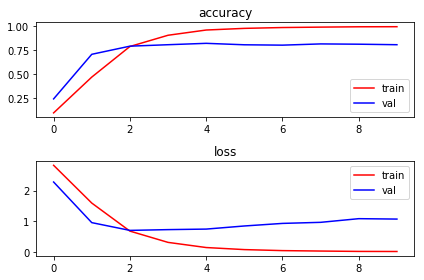

In [15]:
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluate Network

In [16]:
Ytest_ = model.predict(Xtest)
ytest_ = np.argmax(Ytest_, axis=1)
ytest = np.argmax(Ytest, axis=1)
print("accuracy score: {:.3f}".format(accuracy_score(ytest, ytest_)))
print("\nconfusion matrix\n")
print(confusion_matrix(ytest, ytest_))

accuracy score: 0.826

confusion matrix

[[200   2   0   0   0   0   0   0   2   2   0   0   0   0   0  14   2   0
    9   9]
 [  0 205  17  14   7  17   7   3   3   0   0   0   5   4   4   0   1   0
    2   1]
 [  0   8 222  20  10  12   2   3   1   0   0   0   3   4   0   1   0   0
    1   0]
 [  1  10  16 221  21   7  10   0   0   0   0   2  12   0   1   0   0   0
    1   0]
 [  0   6   7  20 220  10   5   4   2   0   0   1  11   5   4   0   0   0
    3   2]
 [  0  12   9   4   6 255   2   0   2   0   1   0   2   4   1   0   0   0
    0   0]
 [  0   5   7  17  10   3 202   5   8   2   1   1  10   5   0   0   1   1
    1   1]
 [  0   0   1   1   4   4   7 237  15   0   0   2   2   2   3   0   2   0
    5   0]
 [  0   0   0   1   1   4   6   1 284   2   0   2   1   2   0   0   0   0
    1   0]
 [  2   4   0   0   1   0   4   9   1 254  14   0   1   0   0   0   1   3
    2   3]
 [  0   2   0   0   0   0   3   1   0  21 261   1   0   1   5   1   2   0
    0   2]
 [  0   0   0   0   2   